# Homemade

In [1]:
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

In [3]:
from qiskit import Aer, transpile, assemble
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    qc = get_var_form(params)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=NUM_SHOTS)
    result = backend.run(qobj).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)])
    return cost

Initial guess :  [0.71980995 0.08125538 0.65299855] 
Optimized Initial guess :  (array([1.58015596, 0.93776178, 0.77203577]), 0.058740118738839164, 41)


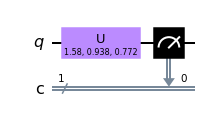

Target Distribution: [0.51357006 0.48642994]
Obtained Distribution: [0.5031, 0.4969]
Output Error (Manhattan Distance): 0.058740118738839164
Parameters Found: [1.58015596 0.93776178 0.77203577]


In [4]:
from qiskit.algorithms.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)
print("Initial guess : ",params,"\nOptimized Initial guess : ",ret)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
display(qc.draw(output = 'mpl'))
t_qc = transpile(qc, backend)
qobj = assemble(t_qc, shots=NUM_SHOTS)
counts = backend.run(qobj).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

# Qiskit made

In [1]:
from qiskit.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library.ansatzes.ucc import UCC
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow.primitive_ops import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.drivers import UnitsType
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

C:\Users\108997~1\AppData\Local\Temp/ipykernel_1848/3513207830.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import CompleteMeasFitter


In [2]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g') #NE MARCHE PAS SUR WINDOWS
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

MissingOptionalLibraryError: "The 'PySCF' library is required to use 'PySCFDriver'. You can install it with 'pip install 'qiskit-nature[pyscf]''.  See https://pyscf.org/install.html."